In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments
import evaluate
import numpy as np
from datasets import load_dataset
import random


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

In [3]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [4]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [5]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

In [7]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
len(tokenizer.vocab)

28996

In [9]:
from transformers import AutoModel

AutoModel.from_pretrained(MODEL)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [10]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [12]:
dataset = dataset.map(preprocess_function, batched=True)

In [13]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

<Axes: >

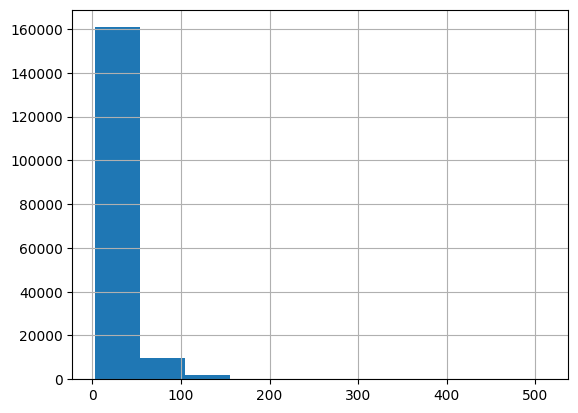

In [14]:
import pandas as pd

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

In [16]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}


In [17]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # some deep learning parameters that the Trainer is able to take in
    warmup_ratio=0.1,
    weight_decay = 0.05,
    
    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 1.554797887802124,
 'eval_accuracy': 0.5844340686997727,
 'eval_runtime': 376.4524,
 'eval_samples_per_second': 153.042,
 'eval_steps_per_second': 4.784}

In [17]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 10,802
  Number of trainable parameters = 65,785,349


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results/checkpoint-10802
Configuration saved in ./bert_clf_results/checkpoint-10802/config.json
Model weights saved in ./bert_clf_results/checkpoint-10802/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results/checkpoint-10802 (score: 0.8207359910011292).


TrainOutput(global_step=10802, training_loss=0.8283754970834909, metrics={'train_runtime': 7323.4982, 'train_samples_per_second': 47.201, 'train_steps_per_second': 1.475, 'total_flos': 7015951744063140.0, 'train_loss': 0.8283754970834909, 'epoch': 2.0})

In [18]:
# See colab link for comparison on there! https://colab.research.google.com/drive/1elfu-6gaj0KWtIQMyeHYWqqkNUgA6hFn?usp=sharing
# compare to fine tuned gpt 3.5
    # accuracy
    # cost to train/host (on HF or make your own API)
    # latency/throughput
    

In [ ]:
trainer.evaluate(dataset['test'])  # run on the testing set to get our final test results

In [ ]:
# Deploy to HuggingFace

trainer.push_to_hub('profoz/distilbert-base-cased-finetuned-stars')

In [15]:
from transformers import pipeline

stars_pipeline = pipeline('text-classification', 'profoz/distilbert-base-cased-finetuned-stars')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [16]:
stars_pipeline(
    [ 
        "I loved this app",
        "I hated this app"
    ]
)

[{'label': 'LABEL_4', 'score': 0.938608705997467},
 {'label': 'LABEL_0', 'score': 0.8552921414375305}]

In [17]:
stars_pipeline.model.config.id2label = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

In [18]:
stars_pipeline(
    [ 
        "I loved this app",
        "I hated this app"
    ]
)

[{'label': '5 stars', 'score': 0.938608705997467},
 {'label': '1 star', 'score': 0.8552921414375305}]

# Using the inference endpoint for our model

In [4]:
import requests

API_URL = "https://t7gvgsj77yrypla7.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

output = query({
	"inputs": "I loved this app",
	"parameters": {}
})
output

[{'label': 'LABEL_4', 'score': 0.938608705997467}]

In [5]:
output = query({
	"inputs": "I hated this app",
	"parameters": {}
})
output

[{'label': 'LABEL_0', 'score': 0.8552921414375305}]